# Google Mobility India data exploration

### Notes on the data:
**Google mobility data:** (https://www.google.com/covid19/mobility/data_documentation.html?hl=en)

* Changes for each day are compared to a baseline value for that day of the week (where the baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020)
* Insights calculated based on data from users who have opted-in to Location History for their Google Account, so the data represents a sample of Google users.

**COVID19-India api data:** (https://api.covid19india.org/csv/)

Specifically the `state_wise_daily.csv` dataset

In [1]:
from pathlib import Path
from typing import Dict, Optional, Sequence, Tuple

import numpy as np
import pandas as pd

from adaptive.etl.covid19india import download_data, load_statewise_data, get_time_series, get_google_mobility_india
from adaptive.utils import cwd, days

In [2]:
root = Path('/Users/caitlinloftus/Projects/adaptive-lockdown/studies/india_districts/')
data = root/"data"

download_data(data, "Global_Mobility_Report.csv", base_url = "https://www.gstatic.com/covid19/mobility/")
download_data(data, "state_wise_daily.csv")

In [3]:
state_df = load_statewise_data(data/"state_wise_daily.csv")
state_level_time_series = get_time_series(state_df, 'state')

In [140]:
google_mobility_india = get_google_mobility_india(data/"Global_Mobility_Report.csv")

/Users/caitlinloftus/Projects/adaptive-lockdown/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/caitlinloftus/Projects/adaptive-lockdown/adaptive/etl/covid19india.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  india_df["sub_region_1"] = india_df["sub_region_1"].str.replace(" and ", " & ")


In [145]:
google_mobility_india['sub_region_1'].fillna('India', inplace=True)

In [147]:
google_mobility_india = google_mobility_india.rename(columns={'sub_region_1':'state'}).set_index(['state','date'])
state_level_time_series.rename_axis(['state','date'], axis=0, inplace=True)

## General trends for India 

### 1. Mobility data

Text(0.5, 1.0, 'Percentage change in mobility across India')

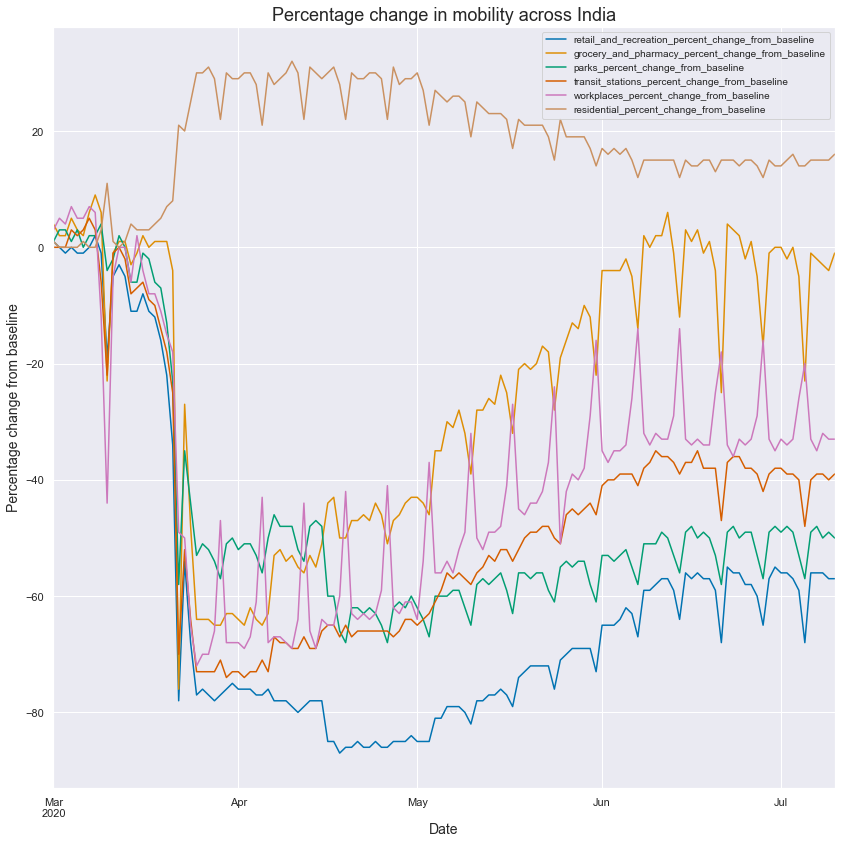

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(14,14))
f = google_mobility_india.loc['India'].loc['2020-03-01':].plot(ax=ax)

plt.legend(loc='upper right', prop={'size': 10})
f.set_xlabel("Date", fontsize=14)
f.set_ylabel("Percentage change from baseline", fontsize=14)
f.set_title("Percentage change in mobility across India", fontsize=18)

### 2. COVID data

Text(0.5, 1.0, 'Number of COVID-19 cases across India')

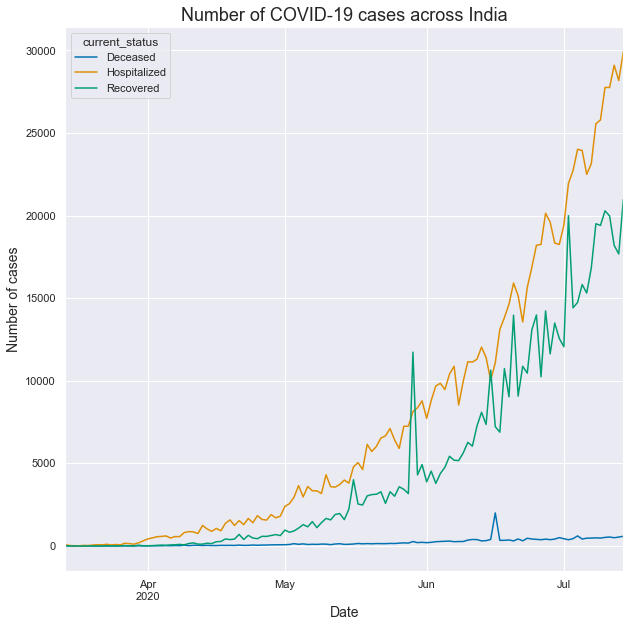

In [151]:
fig, ax = plt.subplots(figsize=(10,10))
f = state_level_time_series.loc['India'].iloc[:,:3].plot(ax=ax)

f.set_xlabel("Date", fontsize=14)
f.set_ylabel("Number of cases", fontsize=14)
f.set_title("Number of COVID-19 cases across India", fontsize=18)

## Joined dataset

In [190]:
joined_df = state_level_time_series.iloc[:,:3].join(google_mobility_india, how='outer')

#### Add time lagged columns
Shift mobility columns by 7 and 14 days 

In [186]:
def add_lag_col(grp):
    for lag in [7, 14]:
        for col in ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']:
            grp[col + '_lag_' + str(lag)] = grp[col].shift(-lag)
    return grp

In [205]:
full_df = joined_df.groupby(level=0).apply(add_lag_col)

In [207]:
total_cases = pd.DataFrame(joined_df.groupby(level=0).apply(lambda x: x['Hospitalized'].sum()))
total_cases = total_cases.reset_index().rename(columns={0:'count'})
states_cases_above_1000 = total_cases['state'][total_cases['count'] > 1000]

In [210]:
df_over_1000_cases = full_df.loc[states_cases_above_1000]

In [215]:
full_df['date'] = full_df.index.get_level_values(level=1)
full_df['week'] = full_df['date'].dt.week

In [216]:
states_weekly = full_df.groupby(['state','week']).sum()

In [217]:
states_weekly.corr()

,Deceased,Hospitalized,Recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline_lag_7,...,parks_percent_change_from_baseline_lag_7,transit_stations_percent_change_from_baseline_lag_7,workplaces_percent_change_from_baseline_lag_7,residential_percent_change_from_baseline_lag_7,retail_and_recreation_percent_change_from_baseline_lag_14,grocery_and_pharmacy_percent_change_from_baseline_lag_14,parks_percent_change_from_baseline_lag_14,transit_stations_percent_change_from_baseline_lag_14,workplaces_percent_change_from_baseline_lag_14,residential_percent_change_from_baseline_lag_14
Deceased,1.000000,0.935939,0.919760,-0.078842,0.004213,-0.103854,-0.057950,-0.086132,0.089184,-0.032658,...,-0.072521,-0.032310,-0.050811,0.035903,0.009342,0.027633,-0.042943,-0.009405,-0.017848,-0.010278
Hospitalized,0.935939,1.000000,0.989886,-0.062791,0.018690,-0.085249,-0.044344,-0.067436,0.066489,-0.003642,...,-0.045419,-0.012688,-0.024341,0.002662,0.046409,0.042685,-0.010903,0.014435,0.012968,-0.050487
Recovered,0.919760,0.989886,1.000000,-0.050303,0.025570,-0.076905,-0.036549,-0.054194,0.047258,0.010363,...,-0.034834,-0.003721,-0.010311,-0.017309,0.059871,0.047865,0.000296,0.023007,0.025938,-0.068181
retail_and_recreation_percent_change_from_baseline,-0.078842,-0.062791,-0.050303,1.000000,0.727464,0.796570,0.840905,0.866846,-0.766874,0.914108,...,0.739444,0.750188,0.752963,-0.658801,0.765368,0.423551,0.627067,0.609261,0.591012,-0.492683
grocery_and_pharmacy_percent_change_from_baseline,0.004213,0.018690,0.025570,0.727464,1.000000,0.803352,0.901740,0.883217,-0.494047,0.719661,...,0.779126,0.850988,0.822750,-0.477583,0.673642,0.767966,0.708055,0.756229,0.728970,-0.426919
parks_percent_change_from_baseline,-0.103854,-0.085249,-0.076905,0.796570,0.803352,1.000000,0.909580,0.869890,-0.527198,0.725540,...,0.924873,0.831893,0.780811,-0.454544,0.622836,0.586549,0.815435,0.724188,0.661012,-0.342093
transit_stations_percent_change_from_baseline,-0.057950,-0.044344,-0.036549,0.840905,0.901740,0.909580,1.000000,0.928929,-0.506362,0.788088,...,0.863067,0.926425,0.846024,-0.451850,0.692081,0.663426,0.765081,0.807277,0.728055,-0.362097
workplaces_percent_change_from_baseline,-0.086132,-0.067436,-0.054194,0.866846,0.883217,0.869890,0.928929,1.000000,-0.692542,0.828526,...,0.841942,0.869988,0.913918,-0.630706,0.748592,0.659871,0.770105,0.770234,0.799637,-0.536565
residential_percent_change_from_baseline,0.089184,0.066489,0.047258,-0.766874,-0.494047,-0.527198,-0.506362,-0.692542,1.000000,-0.733972,...,-0.509474,-0.454998,-0.607335,0.900506,-0.652960,-0.270179,-0.463304,-0.370280,-0.482766,0.744613
retail_and_recreation_percent_change_from_baseline_lag_7,-0.032658,-0.003642,0.010363,0.914108,0.719661,0.725540,0.788088,0.828526,-0.733972,1.000000,...,0.789776,0.836458,0.863703,-0.769754,0.912099,0.593632,0.732466,0.744558,0.745481,-0.659405


In [230]:
full_df.groupby(level=0).apply(lambda x: x[['Hospitalized','workplaces_percent_change_from_baseline',
                                            'workplaces_percent_change_from_baseline_lag_7',
                                            'workplaces_percent_change_from_baseline_lag_14']].corr().loc['Hospitalized'])

Hospitalized,Hospitalized,workplaces_percent_change_from_baseline,workplaces_percent_change_from_baseline_lag_7,workplaces_percent_change_from_baseline_lag_14
state,,,,
Andaman & Nicobar Islands,1.0,0.264746,0.226227,0.067998
Andhra Pradesh,1.0,0.402203,0.541359,0.538379
Arunachal Pradesh,1.0,0.111513,0.083494,0.133768
Assam,1.0,0.153722,0.378495,0.359410
Bihar,1.0,0.538054,0.723169,0.784448
Chandigarh,1.0,0.130975,0.322438,0.407512
Chhattisgarh,1.0,0.513851,0.588846,0.507031
Dadra & Nagar Haveli,1.0,0.267874,0.267053,0.243936
Daman & Diu,NaN,NaN,NaN,NaN


In [70]:
states_weekly.groupby(level=0).apply(lambda x: x.corr().loc['Deceased', 'retail_and_recreation_percent_change_from_baseline':])

Deceased,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
state,,,,,,
Andhra Pradesh,0.394858,0.463623,0.246271,0.423464,0.481783,-0.434894
Assam,0.280426,0.301406,0.297992,0.320621,0.221357,-0.269929
Bihar,0.396920,0.594399,0.622767,0.514310,0.514388,-0.552682
Chhattisgarh,0.200427,0.616928,-0.020235,0.274283,0.439042,-0.439983
Delhi,0.069178,0.382743,-0.243287,0.118233,0.241135,-0.204729
Goa,0.384633,0.348955,0.309949,0.352694,0.369034,-0.366815
Gujarat,-0.357181,0.243079,-0.568546,0.017535,0.053167,0.023870
Haryana,0.131357,0.521085,-0.205706,0.187036,0.310616,-0.347348
Himachal Pradesh,-0.222426,0.094063,-0.316053,-0.011693,0.027161,-0.010049


In [218]:
maharashtra = states_weekly.loc['Maharashtra']

In [219]:
maharashtra_normalized = (maharashtra-maharashtra.mean())/maharashtra.std()

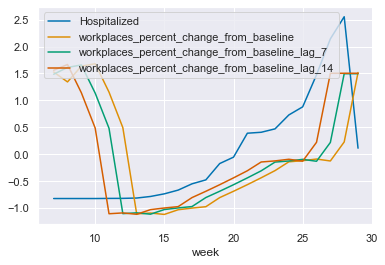

In [223]:
maharashtra_normalized[['Hospitalized', 'workplaces_percent_change_from_baseline','workplaces_percent_change_from_baseline_lag_7','workplaces_percent_change_from_baseline_lag_14']].plot()

In [226]:
maharashtra_normalized[['Hospitalized', 'workplaces_percent_change_from_baseline','workplaces_percent_change_from_baseline_lag_7','workplaces_percent_change_from_baseline_lag_14']].corr()

,Hospitalized,workplaces_percent_change_from_baseline,workplaces_percent_change_from_baseline_lag_7,workplaces_percent_change_from_baseline_lag_14
Hospitalized,1.000000,-0.108180,0.164749,0.405597
workplaces_percent_change_from_baseline,-0.108180,1.000000,0.881317,0.677409
workplaces_percent_change_from_baseline_lag_7,0.164749,0.881317,1.000000,0.883785
workplaces_percent_change_from_baseline_lag_14,0.405597,0.677409,0.883785,1.000000
